In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.data_ingestion_load_data import (
    load_main_data,
    build_data_columns,
    set_muni_index,
)
from utils.japan_area_names import cities_jp_to_en, prefecture_dict_jp_to_en
from utils.fig_handler import HandlerValue, init_savefig

from scipy.optimize import curve_fit
import math

In [3]:
# load config
if os.path.exists("config.json"):
    with open("config.json") as config_file:
        config = json.load(config_file)
else:
    config = dict()

# set the save parameters
save_flag = bool(config.get("save_fig_flag", False))
base_folder = config.get("save_fig_loc", None)
savefig = init_savefig(save_flag, base_folder)

# load data
df = load_main_data()
data_columns = build_data_columns(df)

df["muni"] = df["muni"].map(cities_jp_to_en)
df["pref"] = df["pref"].map(prefecture_dict_jp_to_en)

df = df.set_index(["pref", "muni"])

# sorter based on penetration rate in 2023
pene_rate_2023_rank = (
    (df["rpv_no_2023"] / df["dhouse_total"])
    .sort_values(ascending=False)
    .droplevel(0)
    .index.to_list()
)

# colors
lcolor = ["red", "darkgreen", "blue", "gold", "darkviolet", "peru", "skyblue"]

# markers
markers = ["o", "P", "x"]

# line style
line_style = ["-", "--", ":"]

In [4]:
# ============================================================================ #
# Calculate RPV Numbers
# ============================================================================ #

df_rpv_no = df.filter(like="rpv_no").copy()
df_rpv_no.columns = [int(c.split("_")[-1]) for c in df_rpv_no.columns]
df_rpv_no_growth = df_rpv_no.T.pct_change().dropna().T

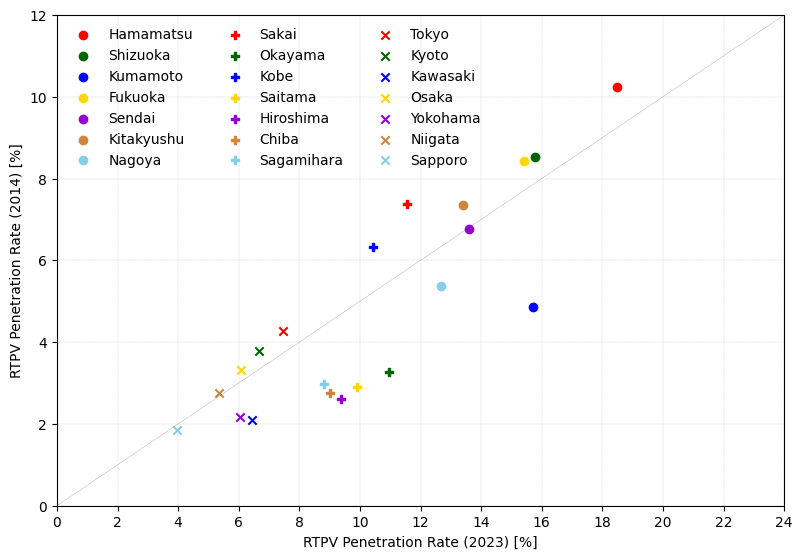

In [5]:
# ============================================================================ #
# Penetration Rate 2014 vs 2023
# ============================================================================ #

fig, ax = plt.subplots(figsize=(8, 5.5))
plt.tight_layout()

penetration_rate_2023 = (
    (df["rpv_no_2023"] / df["dhouse_total"])
    .mul(100)
    .to_frame("pene_rate_2023")
    .droplevel(0)
)
penetration_rate_2014 = (
    (df["rpv_no_2014"] / df["dhouse_total"])
    .mul(100)
    .to_frame("pene_rate_2014")
    .droplevel(0)
)

df_plot = pd.concat([penetration_rate_2014, penetration_rate_2023], axis=1)
df_plot = df_plot.T[pene_rate_2023_rank].T

for i, (muni, data) in enumerate(df_plot.iterrows()):
    ax.scatter(
        data["pene_rate_2023"],
        data["pene_rate_2014"],
        color=lcolor[i % 7],
        marker=markers[i // 7],
        label=muni,
    )
ax.plot([0, 24], [0, 12], color="k", linestyle="-", linewidth=0.1)

ax.legend(loc="upper left", edgecolor="white", framealpha=0, ncol=3)
ax.set_xlabel("RTPV Penetration Rate (2023) [%]")
ax.set_ylabel("RTPV Penetration Rate (2014) [%]")

ax.set_ylim(0, 12)
ax.set_xticks(range(0, 24 + 1, 2))
ax.set_xlim(0, 24)

ax.grid(axis="both", lw=0.2, ls="--")
ax.set_axisbelow(True)

savefig(fig, "rtpv_penetration_rate_2014.pdf", dpi=300)

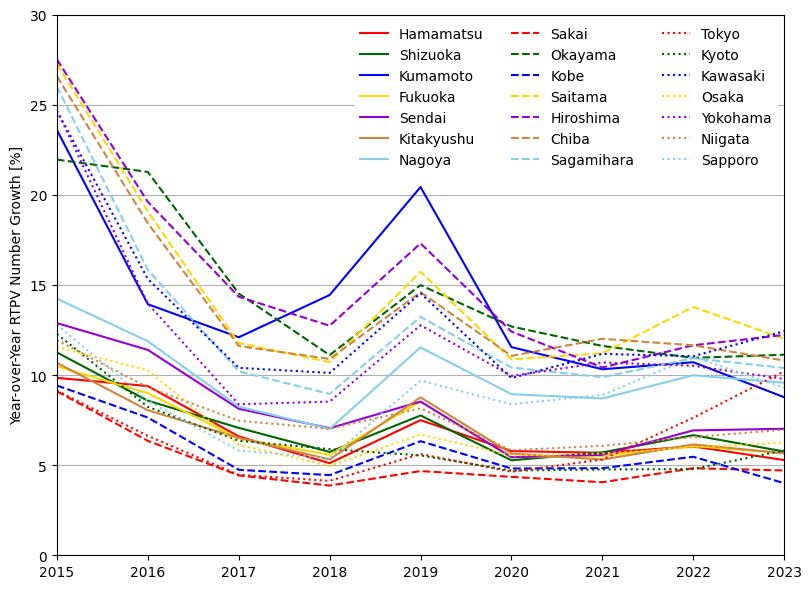

In [6]:
# ============================================================================ #
# Year-over-year Rooftop PV Number Growth Rate
# ============================================================================ #

fig, ax = plt.subplots(figsize=(8, 6))
plt.tight_layout()
df_plot = df_rpv_no_growth.droplevel(0).mul(100).T

lcolor = ["red", "darkgreen", "blue", "gold", "darkviolet", "peru", "skyblue"]

for i, col in enumerate(pene_rate_2023_rank):
    df_plot[col].plot(ax=ax, color=lcolor[i % 7], ls=line_style[i // 7])
ax.legend(loc="upper right", edgecolor="white", framealpha=1, ncol=3)
ax.set_ylabel("Year-over-Year RTPV Number Growth [%]")

ax.set_ylim(0, 30)
ax.set_xlim(2015, 2023)

ax.grid(axis="y")
ax.set_axisbelow(True)

savefig(fig, "year_over_year_rtpv_growth.pdf", dpi=300)

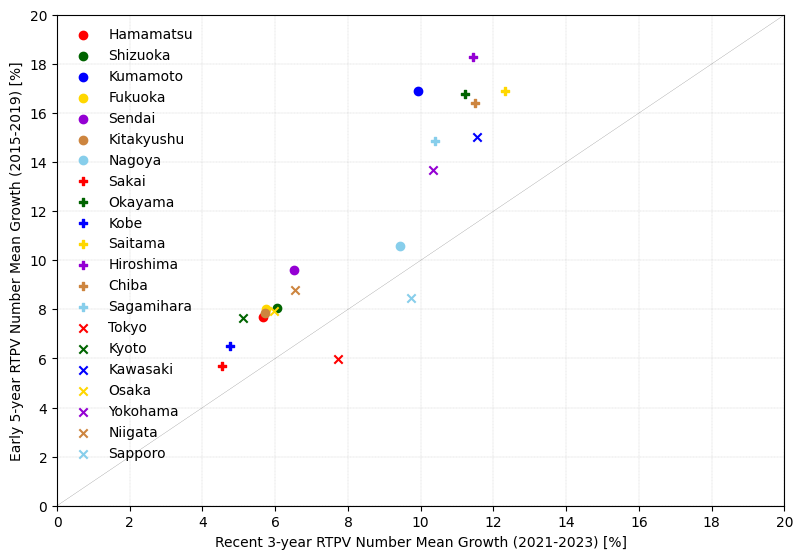

In [7]:
# ============================================================================ #
# Comparison of Growth
# ============================================================================ #

fig, ax = plt.subplots(figsize=(8, 5.5))
plt.tight_layout()
markers = ["o", "P", "x"]

mean_growth = [
    (
        df_rpv_no_growth[list(range(2015, 2020))]
        .mean(axis=1)
        .mul(100)
        .to_frame("mean_growth_head")
        .droplevel(0)
    ),
    (
        df_rpv_no_growth[list(range(2021, 2024))]
        .mean(axis=1)
        .mul(100)
        .to_frame("mean_growth_tail")
        .droplevel(0)
    ),
]
mean_growth = pd.concat(mean_growth, axis=1)


df_plot = mean_growth.sort_values("mean_growth_tail", ascending=False)
df_plot = df_plot.T[pene_rate_2023_rank].T

for i, (muni, data) in enumerate(df_plot.iterrows()):
    ax.scatter(
        data["mean_growth_tail"],
        data["mean_growth_head"],
        color=lcolor[i % 7],
        marker=markers[i // 7],
        label=muni,
    )
ax.plot([0, 20], [0, 20], color="k", linestyle="-", linewidth=0.1)

ax.set_xlabel("Recent 3-year RTPV Number Mean Growth (2021-2023) [%]")
ax.set_ylabel("Early 5-year RTPV Number Mean Growth (2015-2019) [%]")

ax.legend(loc="upper left", edgecolor="white", framealpha=0)


ax.set_ylim(0, 20)
ax.set_yticks(range(0, 20 + 1, 2))
ax.set_xlim(0, 20)
ax.set_xticks(range(0, 20 + 1, 2))


ax.grid(axis="both", lw=0.2, ls="--")
ax.set_axisbelow(True)
savefig(fig, "rtpv_growth_comparison.pdf", dpi=300)

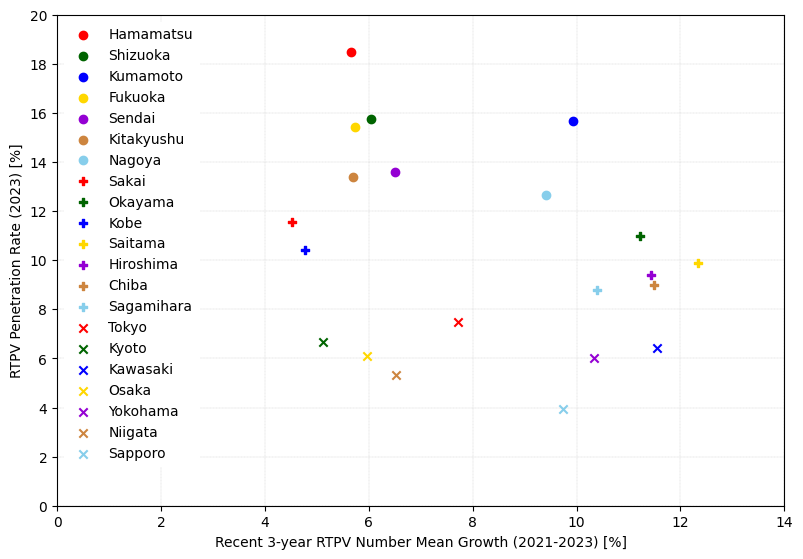

In [8]:
# ============================================================================ #
# Recent Growth Rate vs Penetration Rate
# ============================================================================ #

fig, ax = plt.subplots(figsize=(8, 5.5))
plt.tight_layout()
markers = ["o", "P", "x"]

recent_mean_growth = (
    df_rpv_no_growth[list(range(2021, 2024))]
    .mean(axis=1)
    .mul(100)
    .to_frame("mean_growth")
    .droplevel(0)
)
penetration_rate_2023 = (
    (df["rpv_no_2023"] / df["dhouse_total"])
    .mul(100)
    .to_frame("pene_rate_2023")
    .droplevel(0)
)
df_plot = pd.concat([recent_mean_growth, penetration_rate_2023], axis=1)
df_plot = df_plot.T[pene_rate_2023_rank].T

for i, (muni, data) in enumerate(df_plot.iterrows()):
    ax.scatter(
        data["mean_growth"],
        data["pene_rate_2023"],
        color=lcolor[i % 7],
        marker=markers[i // 7],
        label=muni,
    )

ax.legend(loc="upper left", edgecolor="white", framealpha=1)
ax.set_xlabel("Recent 3-year RTPV Number Mean Growth (2021-2023) [%]")
ax.set_ylabel("RTPV Penetration Rate (2023) [%]")


ax.set_ylim(0, 20)
ax.set_yticks(range(0, 20 + 1, 2))
ax.set_xlim(0, 14)

ax.grid(axis="both", lw=0.2, ls="--")
ax.set_axisbelow(True)
savefig(fig, "rtpv_pene_vs_growth.pdf", dpi=300)

## Logistic Growth


In [9]:
# ============================================================================ #
# Logistic Growth
# ============================================================================ #

def logistic_growth(t, N0, r, M, t0):
    """
    Logistic growth model function.

    This function models the growth of a population (or a target variable like solar PV capacity)
    using the logistic growth equation with a specified carrying capacity and growth rate. The logistic
    growth curve starts with exponential growth but levels off as it approaches a maximum population.

    Parameters:
    ----------
    t : float or array-like
        The time variable, typically representing years.
    N0 : float
        The initial population (or initial value of the target variable) at time t0.
    r : float
        The growth rate of the population. This determines how fast the population grows.
    M : float
        The maximum population (carrying capacity), which the population will asymptotically approach.
    t0 : float
        The time offset (initial time) when the initial population N0 is observed.

    Returns:
    -------
    float or array-like
        The population (or target variable) at time t, following the logistic growth model.

    """
    return M / (1 + ((M - N0) / N0) * np.exp(-r * (t - t0)))


def extract_target_var(dfx, filter_str):
    df_val = dfx.filter(like=filter_str)

    # Extract the year from the column names, append "-12-31" for year-end, and convert to datetime format
    years = (
        df_val.index.to_series().apply(lambda x: f"{x.split('_')[-1]}-12-31").tolist()
    )

    # Set the index as years and convert to datetime
    df_val.index = pd.to_datetime(years)

    return df_val


def fit_logistic_curve_pv_no(dfx, targets):
    # Extract main data
    data = extract_target_var(dfx, "rpv_no")

    # Values
    years = data.index.year.to_list()
    capacity = data.values.tolist()

    # Known maximum population (M)
    M_known = dfx["dhouse_total"].item()
    t0_known = 2000

    # Define the logistic growth model with a fixed M
    def logistic_growth_known_vals(t, N0, r):
        return logistic_growth(t, N0, r, M_known, t0_known)

    # Add target value
    for year, pop_ratio in targets:
        years.append(year)
        capacity.append(M_known * pop_ratio)

    # Set initial guesses for the parameters
    N0_guess = capacity[0]
    r_guess = 0.10
    t0_guess = years[0]

    # Set bounds for the parameters to prevent overflow
    # Bounds for N0, r, t0
    bounds = ([0, 0], [capacity[0], 1.0])

    # Fit the logistic growth curve to the data using curve_fit (with fixed M)
    popt, pcov = curve_fit(
        logistic_growth_known_vals,
        years,
        capacity,
        p0=[N0_guess, r_guess],
        bounds=bounds,
    )

    return logistic_growth_known_vals, popt, years, capacity

In [10]:
def calc_rms(df):
    differences = df["actual"] - df["predicted"]
    squared_differences = differences**2
    mean_squared_difference = np.mean(squared_differences)
    rms = np.sqrt(mean_squared_difference)
    return rms

def calc_r2(df):
    actual = df["actual"]
    predicted = df["predicted"]

    ss_total = np.sum((actual - np.mean(actual)) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)

    r2 = 1 - (ss_residual / ss_total).item()
    return r2

def ceil_to_1000(value):
    return math.ceil(value / 1_000) * 1_000

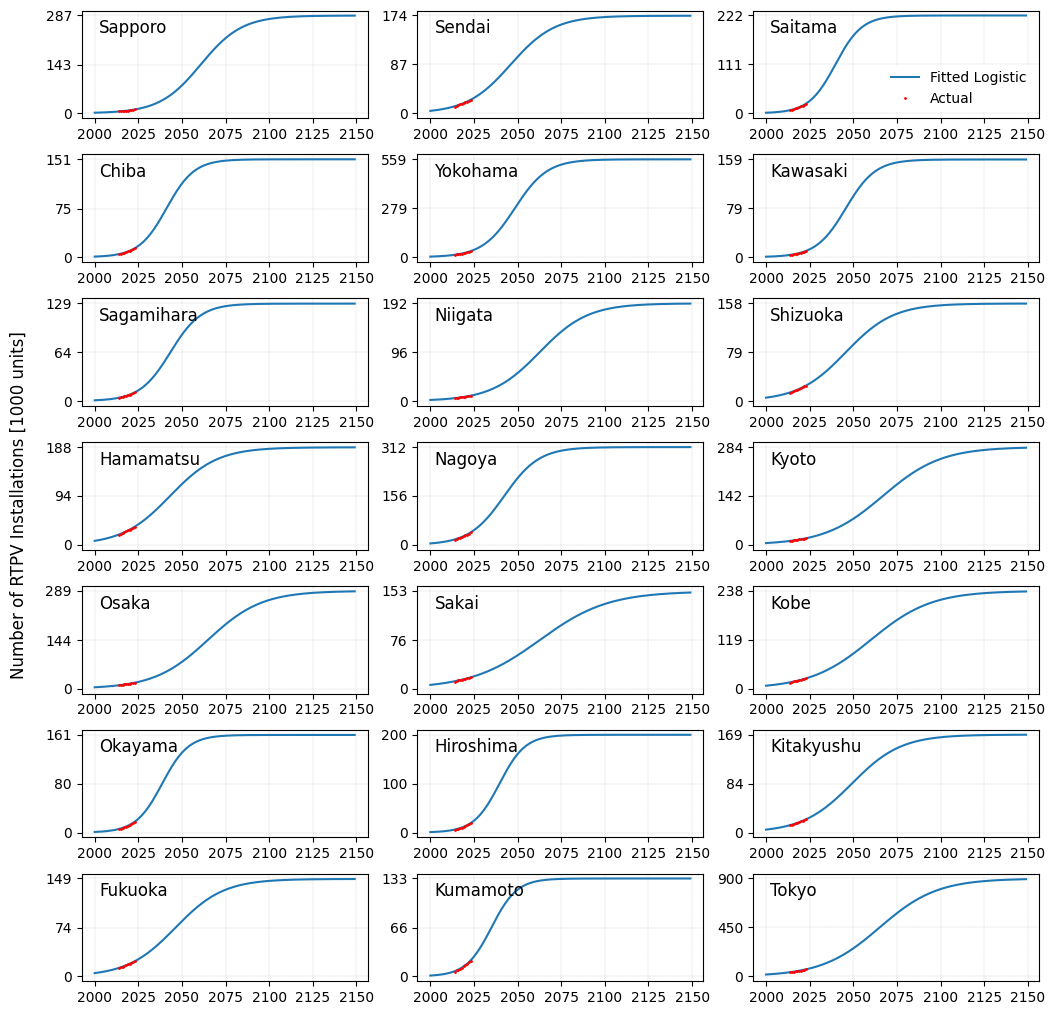

In [11]:
# ============================================================================ #
# Forecast the growth of rooftop photovoltaic 
# ============================================================================ #

# plot
fig, axs = plt.subplots(7, 3, figsize=(10, 10))
plt.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)
axs = [item for sublist in axs for item in sublist]
pv_no_max = df["dhouse_total"].droplevel(0).apply(ceil_to_1000)

# Estimate the current growth rate
penetration_rate_2023 = (
    (df["rpv_no_2023"] / df["dhouse_total"])
    .mul(100)
    .to_frame("pene_rate_2023")
    .droplevel(0)
)
penetration_rate_2014 = (
    (df["rpv_no_2014"] / df["dhouse_total"])
    .mul(100)
    .to_frame("pene_rate_2014")
    .droplevel(0)
)
growth_10_year = (
    penetration_rate_2023["pene_rate_2023"] / penetration_rate_2014["pene_rate_2014"]
)
data = []
df_predicted_muni = []
for i, muni in enumerate(growth_10_year.index.to_list()):
    muni_data = {}
    dfx = df.droplevel(0).loc[muni]

    # the target assumes that the growth in the past 10 years will be the same
    # in the next 10 years
    pene_rate_2023 = dfx["rpv_no_2023"] / dfx["dhouse_total"]
    target = [(2032, pene_rate_2023 * growth_10_year.loc[muni])]
    target = []
    logistic_growth_known_vals, popt, years, capacity = fit_logistic_curve_pv_no(
        dfx, target
    )

    # Create a range of years from t0_known to 2050
    years_range = np.arange(2014, 2024)

    df_compare = extract_target_var(dfx, "rpv_no").to_frame("actual")
    df_compare["predicted"] = logistic_growth_known_vals(years_range, *popt)

    muni_data["muni"] = muni
    muni_data["r2"] = calc_r2(df_compare)
    muni_data["growth_rate"] = round(100 * popt[1], 2)

    # predict
    years_range = np.arange(2000, 2150)
    df_predicted = pd.DataFrame(
        logistic_growth_known_vals(years_range, *popt),
        index=years_range,
        columns=["predicted"],
    )
    predicted_dict = (
        df_predicted[df_predicted.index.isin(range(2030, 2051, 5))]["predicted"]
        .round(0)
        .astype(int)
        .to_dict()
    )
    muni_data.update(predicted_dict)

    df_predicted.div(1000).plot(ax=axs[i])

    df_actual_plot = df_compare["actual"].copy()
    df_actual_plot.index = df_actual_plot.index.year
    df_actual_plot.div(1000).to_frame("actual").plot(
		ax=axs[i], color="red", lw=0, marker="o", markersize=1
	)

    axs[i].text(
		0.06,
		0.92,
		muni,
		transform=axs[i].transAxes,
		fontsize=12,
		verticalalignment="top",
	)

    axs[i].legend().set_visible(False)
    max_y = int(pv_no_max.loc[muni].item() / 1_000)
    axs[i].set_ylim(-max_y * 0.05, max_y * 1.05)
    axs[i].set_yticks([0, max_y // 2, max_y])

    axs[i].grid(axis="both", lw=0.2, ls="--")
    axs[i].set_axisbelow(True)
    axs[i].set_xlabel("")
    axs[i].set_xticks(range(2000, years_range[-1]+2,25))

    data.append(muni_data)
    df_predicted_muni.append(df_predicted["predicted"].to_frame(muni))

fig.text(
    -0.04,
    0.5,
    "Number of RTPV Installations [1000 units]",
    va="center",
    rotation="vertical",
    fontsize=12,
)

handles, labels = axs[2].get_legend_handles_labels()
rename_cols = {
    "predicted": "Fitted Logistic",
    "actual": "Actual",
    "target": "Estimated",
}
labels = [rename_cols.get(l, l) for l in labels]
axs[2].legend(handles, labels, loc="lower right", edgecolor="white", framealpha=1)

predicted_pv_no = pd.DataFrame(data)
predicted_pv_no = predicted_pv_no.set_index("muni")
predicted_pv_no

df_predicted_muni = pd.concat(df_predicted_muni, axis=1)

savefig(fig, "logistic_growth_curve.pdf", dpi=300);

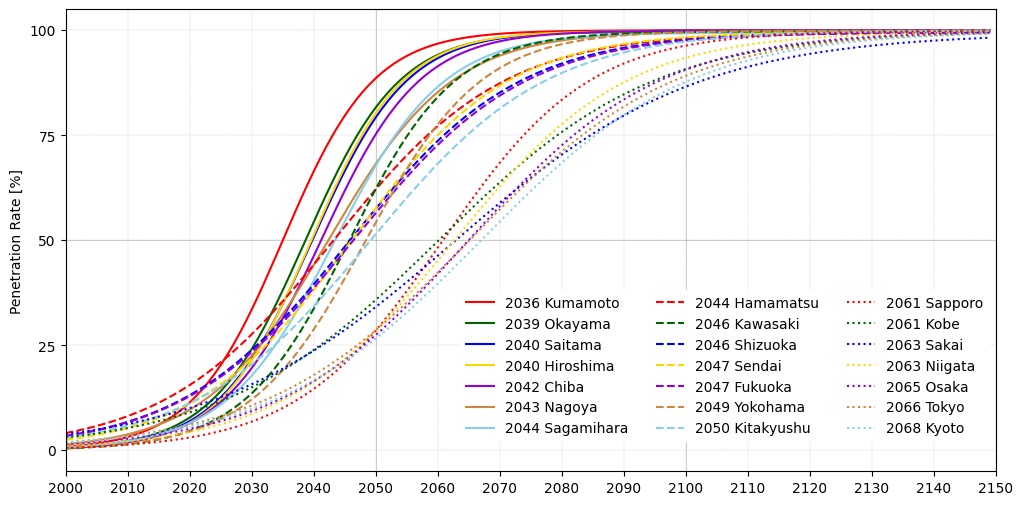

In [12]:
# ============================================================================ #
# Calculate the predicted municipality growth rate
# ============================================================================ #

df_predicted_muni_rate = df_predicted_muni / pv_no_max

threshold = 0.5
year_50_per = (df_predicted_muni_rate >= threshold).idxmax()
cols = year_50_per.sort_values().index
fig, ax = plt.subplots(figsize=(12, 6))
df_plot = df_predicted_muni_rate[cols].T

ax.axhline(y=0.5, lw=0.5, ls="-", color="grey", alpha=0.5)
ax.axvline(x=2050, lw=0.5, ls="-", color="grey", alpha=0.5)
ax.axvline(x=2100, lw=0.5, ls="-", color="grey", alpha=0.5)

for i, (muni, data) in enumerate(df_plot.iterrows()):
    ax.plot(
        data,
        color=lcolor[i % 7],
        ls=line_style[i // 7],
        label=f"{year_50_per.to_dict()[muni]} {muni}",
    )

ax.legend(
    loc="lower right", edgecolor="White", framealpha=1, ncol=3, bbox_to_anchor=(1, 0.05)
)

ax.set_xlim(2000, 2150)
ax.set_ylim(-0.05, 1.05)

yticks = [round(t / 100, 2) for t in range(0, 101, 25)]
ax.set_yticks(yticks)
ax.set_yticklabels([int(y * 100) for y in yticks])
ax.set_xticks(range(2000, 2151, 10))

ax.grid(axis="both", lw=0.2, ls="--")
ax.set_axisbelow(True)

ax.set_ylabel("Penetration Rate [%]")

savefig(fig, "logistic_growth_comparison.pdf", dpi=300)